# Projet 8 :  Participez à la conception d'une voiture autonome
## Projet 8 : Selection du model
<font color = "grey"><i> Chargement des modules necessaires </i></font>


* Définition de l'environnement et inscription dans l'espace de travail:

In [1]:
from azureml.core.authentication import InteractiveLoginAuthentication
from azureml.core.conda_dependencies import CondaDependencies
from azureml.core.workspace import Workspace
from azureml.core.environment import Environment
import azureml.core
from PIL import Image
import tensorflow as tf
import os
from matplotlib import colors
import random
import imgaug.augmenters as iaa
from tensorflow.keras.utils import Sequence
from tensorflow.python.keras import backend as K

from tensorflow import keras
import time


In [2]:
#Tenant_id

tenant_id_key = 'AZURE_WORKSPACE_P7_ID_TENANT'
if not tenant_id_key in os.environ:
    raise Exception('Please set/export the environment variable 1: {}'.format(tenant_id_key))

else:
    tenant_id = os.environ[tenant_id_key]

project_name_env= 'AZURE_WORKSPACE_P7_NAME'
if not project_name_env in os.environ:
    raise Exception('Please set/export the environment variable 1: {}'.format(project_name_env))
else:
    project_name = os.environ[project_name_env]


client_id_key = 'AZURE_WORKSPACE_P7_KEY'
if not client_id_key in os.environ:
    raise Exception('Please set/export the environment variable 1: {}'.format(client_id_key))
else:
    subscription_key = os.environ[client_id_key]

workspace_name = 'AZURE_WORKSPACE'
if not workspace_name in os.environ:
    raise Exception('Please set/export the environment variable 1: {}'.format(workspace_name))

else:
    resource_group = os.environ[workspace_name]




ia = InteractiveLoginAuthentication(tenant_id=tenant_id)
#ws = Workspace(subscription_id,resource_group,workspace_name)
ws = Workspace.get(name=project_name,
                    subscription_id=subscription_key,
                    resource_group=resource_group,auth=ia)


env = Environment('env-sentiment')
cd = CondaDependencies.create(pip_packages=['azureml-dataset-runtime[pandas,fuse]', 'azureml-defaults'],
                                            conda_packages=['scikit-learn==0.22.1','tensorflow==1.15.5'
                                            'numpy==1.18.5', 'gensim==3.8.3', 'joblib==0.14.1'])

env.python.conda_dependencies = cd

env.register(workspace=ws)

The default web browser has been opened at https://login.microsoftonline.com/293dc2d7-d1da-43ed-a274-9cc32cb29098/oauth2/v2.0/authorize. Please continue the login in the web browser. If no web browser is available or if the web browser fails to open, use device code flow with `az login --use-device-code`.


Performing interactive authentication. Please follow the instructions on the terminal.
Interactive authentication successfully completed.


{
    "databricks": {
        "eggLibraries": [],
        "jarLibraries": [],
        "mavenLibraries": [],
        "pypiLibraries": [],
        "rcranLibraries": []
    },
    "docker": {
        "arguments": [],
        "baseDockerfile": null,
        "baseImage": "mcr.microsoft.com/azureml/openmpi3.1.2-ubuntu18.04:20211124.v1",
        "baseImageRegistry": {
            "address": null,
            "password": null,
            "registryIdentity": null,
            "username": null
        },
        "enabled": false,
        "platform": {
            "architecture": "amd64",
            "os": "Linux"
        },
        "sharedVolumes": true,
        "shmSize": null
    },
    "environmentVariables": {
        "EXAMPLE_ENV_VAR": "EXAMPLE_VALUE"
    },
    "inferencingStackVersion": null,
    "name": "env-sentiment",
    "python": {
        "baseCondaEnvironment": null,
        "condaDependencies": {
            "channels": [
                "anaconda",
                "conda-forge"


In [2]:
# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

# Connection to a Workspace

In [4]:

cwd = os.getcwd()
CURRENT_WORKING_DIRRECTORY = os.getcwd()
# Print the current working directory
print("Current working directory: {0}".format(CURRENT_WORKING_DIRRECTORY))



DESTINATION_PATH = CURRENT_WORKING_DIRRECTORY+'\data\images\img_128_256'
print("Resize path directory is directory: {0}".format(DESTINATION_PATH))

Current working directory: C:\Users\marj1\PycharmProjects\Project8
Resize path directory is directory: C:\Users\marj1\PycharmProjects\Project8\data\images\img_128_256


In [5]:
image_train_path=DESTINATION_PATH+"\\train"
mask_train_path=DESTINATION_PATH+"\\masks"

image_test_path=DESTINATION_PATH+"\\test\\test"
mask_test_path=DESTINATION_PATH+"\\test\mask"

image_val_path=DESTINATION_PATH+"\\validation\images"
mask_val_path=DESTINATION_PATH+"\\validation\mask"

In [6]:
image_train_filename = os.listdir(image_train_path)
mask_train_filename = os.listdir(mask_train_path)
image_train_filename.sort()
mask_train_filename.sort()

image_test_filename = os.listdir(image_test_path)
mask_test_filename = os.listdir(mask_test_path)
image_test_filename.sort()
mask_test_filename.sort()



image_val_filename = os.listdir(image_val_path)
mask_val_filename = os.listdir(mask_val_path)
image_val_filename.sort()
mask_val_filename.sort()

# Utilities

In [7]:
def create_mask(img,cats):
    img = tf.keras.preprocessing.image.img_to_array(img,dtype=np.int32) # convert img to np.array
    img=np.squeeze(img) #remove 1 dimension
    mask = np.zeros((img.shape[0], img.shape[1], len(cats)),dtype=int) # create a mask with zeros
    flat_cat = [val for cat in list(cats.values()) for val in cat] # create a list of all values associated with categories
    ca_min = min(flat_cat)
    ca_max = max(flat_cat)
    cats_names = list(cats.keys())

    #for each values associated with a category, fill in the mask with the corresponding category number
    for i in range(ca_min,ca_max):
            for idx,name in enumerate(cats_names):
                if i in cats[name]:
                    mask[:,:,idx] = np.logical_or(mask[:,:,idx],(img==i))
    return mask


def generate_img_from_mask(mask,cats):
    colors_palette=['b','g','r','c','m','y','k','w']
    img_seg = np.zeros((mask.shape[0],mask.shape[1],3),dtype='float')
    for cat in range(len(cats)):
        img_seg[:,:,0] += mask[:,:,cat]*colors.to_rgb(colors_palette[cat])[0]
        img_seg[:,:,1] += mask[:,:,cat]*colors.to_rgb(colors_palette[cat])[1]
        img_seg[:,:,2] += mask[:,:,cat]*colors.to_rgb(colors_palette[cat])[2]

    return tf.keras.preprocessing.image.array_to_img(img_seg)

def normalize_input_img(img):
    img =tf.keras.preprocessing.image.img_to_array(img,dtype=np.int32)
    img = img/127.5
    img -= 1
    return img

def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst


def show_results(img,mask,model):
    img_norm = np.array(normalize_input_img(img))
    img_pred = model.predict(img_norm.reshape(1,128,256,3))[0]
    res = get_concat_h(get_concat_h(img,generate_img_from_mask(create_mask(mask,cats),cats)),generate_img_from_mask(img_pred,cats))

    return res

# Creating the model

In [8]:
#https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
vgg_weights_path = "vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [9]:
def block(x, n_convs, filters, kernel_size, activation, pool_size, pool_stride, block_name):
  for i in range(n_convs):
      x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size,
                                 activation=activation, padding='same', name="{}_conv{}".format(block_name, i + 1))(x)

  x = tf.keras.layers.MaxPooling2D(pool_size=pool_size,
                                   strides=pool_stride, name="{}_pool{}".format(block_name, i+1 ))(x)

  return x

In [10]:
def VGG_16(image_input):
  # create 5 blocks with increasing filters at each stage.
  # you will save the output of each block (i.e. p1, p2, p3, p4, p5). "p" stands for the pooling layer.
  x = block(image_input,n_convs=2, filters=64, kernel_size=(3,3),
            activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block1')
  p1= x

  x = block(x,n_convs=2, filters=128, kernel_size=(3,3),
            activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block2')
  p2 = x

  x = block(x,n_convs=3, filters=256, kernel_size=(3,3),
            activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block3')
  p3 = x

  x = block(x,n_convs=3, filters=512, kernel_size=(3,3),
            activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block4')
  p4 = x

  x = block(x,n_convs=3, filters=512, kernel_size=(3,3),
            activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block5')
  p5 = x

  # create the vgg model
  vgg  = tf.keras.Model(image_input , p5)

  # load the pretrained weights you downloaded earlier
  vgg.load_weights(vgg_weights_path)

  # number of filters for the output convolutional layers
  n = 4096

  # our input images are 224x224 pixels so they will be downsampled to 7x7 after the pooling layers above.
  # we can extract more features by chaining two more convolution layers.
  c6 = tf.keras.layers.Conv2D( n , ( 7 , 7 ) , activation='relu' , padding='same', name="conv6")(p5)
  c7 = tf.keras.layers.Conv2D( n , ( 1 , 1 ) , activation='relu' , padding='same', name="conv7")(c6)

  # return the outputs at each stage. you will only need two of these in this particular exercise
  # but we included it all in case you want to experiment with other types of decoders.
  return (p1, p2, p3, p4, c7)

In [11]:
def fcn8_decoder(convs, n_classes):
  # unpack the output of the encoder
  f1, f2, f3, f4, f5 = convs

  # upsample the output of the encoder then crop extra pixels that were introduced
  o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False )(f5)
  o = tf.keras.layers.Cropping2D(cropping=(1,1))(o)

  # load the pool 4 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
  o2 = f4
  o2 = ( tf.keras.layers.Conv2D(n_classes , ( 1 , 1 ) , activation='relu' , padding='same'))(o2)

  # add the results of the upsampling and pool 4 prediction
  o = tf.keras.layers.Add()([o, o2])

  # upsample the resulting tensor of the operation you just did
  o = (tf.keras.layers.Conv2DTranspose( n_classes , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False ))(o)
  o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

  # load the pool 3 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
  o2 = f3
  o2 = ( tf.keras.layers.Conv2D(n_classes , ( 1 , 1 ) , activation='relu' , padding='same'))(o2)

  # add the results of the upsampling and pool 3 prediction
  o = tf.keras.layers.Add()([o, o2])

  # upsample up to the size of the original image
  o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(8,8) ,  strides=(8,8) , use_bias=False )(o)

  # append a softmax to get the class probabilities
  o = (tf.keras.layers.Activation('softmax'))(o)

  return o

In [12]:
def segmentation_model():
  inputs = tf.keras.layers.Input(shape=(128,256,3))
  convs = VGG_16(image_input=inputs)
  outputs = fcn8_decoder(convs, 8)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model

In [13]:
model_fcn8 = segmentation_model()
model_fcn8.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 128, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool2 (MaxPooling2D)     (None, 64, 128, 64)  0           block1_conv2[0][0]               
___________

# Metrics

In [14]:
def wise_IoU(y_true,y_pred):

    nb_class = y_true.shape[3]
    # for each pixel, get the slice number which has the highest probability
    y_true = K.argmax(y_true, axis=3)
    y_pred = K.argmax(y_pred,axis=3)

    wise_iou = []

    smoothening_factor = 0.00001 # to avoid eventual division by 0

    for i in range(nb_class):
        pred = tf.cast((y_pred == i),tf.float32)
        truth = tf.cast((y_true == i),tf.float32)
        intersection = K.sum(pred * truth)
        y_true_area = K.sum(truth)
        y_pred_area = K.sum(pred)
        combined_area = y_true_area + y_pred_area

        iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
        wise_iou.append(iou)

    return tf.convert_to_tensor(wise_iou)

In [15]:
def mean_IoU(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)
    return score

# Datagenerators and augmentation

In [16]:
def blur_img(img):
    n = random.uniform(0,2.0) # Generating random value for sigma
    blur_transform = iaa.Sequential([iaa.GaussianBlur(sigma=n)])
    img_blur = blur_transform(image=tf.keras.preprocessing.image.img_to_array(img))

    return tf.keras.preprocessing.image.array_to_img(img_blur)

def zoom_img(img,mask):
    n = random.uniform(1,5) # Generating random value for sigma
    zoom_transform = iaa.Sequential([iaa.Affine(scale=n,order=0)]) # uses order=0 to avoid artifacts in mask
    img_zoom = zoom_transform(image=tf.keras.preprocessing.image.img_to_array(img))
    mask_zoom = zoom_transform(image=tf.keras.preprocessing.image.img_to_array(mask))

    return tf.keras.preprocessing.image.array_to_img(img_zoom), tf.keras.preprocessing.image.array_to_img(mask_zoom,scale=False)

def brightness_img(img):
    br_transform = iaa.Sequential([iaa.MultiplyBrightness((0.1,2))])
    img_br = br_transform(image=tf.keras.preprocessing.image.img_to_array(img).astype(np.uint8))

    return tf.keras.preprocessing.image.array_to_img(img_br,scale=False)

def flip_img(img,mask):
    flip_transform = iaa.Sequential([iaa.Fliplr()])
    img_flip = flip_transform(image=tf.keras.preprocessing.image.img_to_array(img))
    mask_flip = flip_transform(image=tf.keras.preprocessing.image.img_to_array(mask))

    return tf.keras.preprocessing.image.array_to_img(img_flip), tf.keras.preprocessing.image.array_to_img(mask_flip,scale=False)

In [17]:
class seg_gen(Sequence):

    def __init__(self, image_dir,
                 mask_dir,
                 batch_size,
                 img_height,
                 img_width,
                 cats,
                 sample_perc=100,
                 aug_blur=False,
                 aug_zoom=False,
                 aug_brightness=False,
                 aug_flip=False):

        self.image_dir = image_dir
        self.mask_dir =  mask_dir
        self.image_filename =  os.listdir(image_dir)
        self.image_filename.sort()
        self.mask_filename =  os.listdir(mask_dir)
        self.mask_filename.sort()
        self.sample_perc = sample_perc
        # Generate a sample
        rdm_index = random.sample(range(0,len(self.image_filename)),int(len(self.image_filename)*self.sample_perc/100))
        image_filename_sample = []
        for i in rdm_index:
            image_filename_sample.append(self.image_filename[i])

        mask_filename_sample = []
        for i in rdm_index:
            mask_filename_sample.append(self.mask_filename[i])

        self.image_filename = image_filename_sample
        self.mask_filename = mask_filename_sample

        self.batch_size = batch_size
        self.img_height = img_height
        self.img_width = img_width
        self.cats = cats
        self.sample_perc = sample_perc
        self.aug_blur = aug_blur
        self.aug_zoom = aug_zoom
        self.aug_brightness = aug_brightness
        self.aug_flip = aug_flip

    def __len__(self):
        return int(np.ceil(len(self.image_filename) / float(self.batch_size)))

    def __getitem__(self, idx):
        idx = np.random.randint(0,len(self.image_filename)-1, self.batch_size) #generate random index for the batch
        batch_img, batch_mask = [], []

        for i in idx:

            img_file = self.image_dir+'/'+self.image_filename[i]
            mask_file = self.mask_dir+'/'+self.mask_filename[i]

            img = tf.keras.preprocessing.image.load_img(img_file,target_size=(self.img_height,self.img_width))
            mask = tf.keras.preprocessing.image.load_img(mask_file,target_size=(128,256),color_mode="grayscale")

            img_norm = normalize_input_img(img)
            mask_tensor = create_mask(mask,self.cats)

            batch_img.append(img_norm)
            batch_mask.append(mask_tensor)

            #Image augmentation
            if self.aug_blur:
                batch_img.append(normalize_input_img(blur_img(img)))
                batch_mask.append(mask_tensor) # When using blur augmentation,the mask is not changed

            if self.aug_zoom:
                zooms = zoom_img(img,mask)
                batch_img.append(normalize_input_img(zooms[0]))
                batch_mask.append(create_mask(zooms[1],self.cats))

            if self.aug_brightness:
                batch_img.append(normalize_input_img(brightness_img(img)))
                batch_mask.append(mask_tensor) # When using brightness augmentation,the mask is not changed

            if self.aug_flip:
                flips = flip_img(img,mask)
                batch_img.append(normalize_input_img(flips[0]))
                batch_mask.append(create_mask(flips[1],self.cats))


        return np.array(batch_img), np.array(batch_mask)

In [18]:
cats = {'void': [0, 1, 2, 3, 4, 5, 6],
 'flat': [7, 8, 9, 10],
 'construction': [11, 12, 13, 14, 15, 16],
 'object': [17, 18, 19, 20],
 'nature': [21, 22],
 'sky': [23],
 'human': [24, 25],
 'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]}

In [19]:
train_gen = seg_gen(image_train_path,mask_train_path,10,128,256,cats,sample_perc=10,aug_blur=False,aug_zoom=True,aug_brightness=False,aug_flip=True)

In [20]:
val_gen = seg_gen(image_val_path,mask_val_path,10,128,256,cats,sample_perc=50,aug_blur=False,aug_zoom=False,aug_brightness=False,aug_flip=False)

# Callbacks

Early Stopping

In [21]:
es = tf.keras.callbacks.EarlyStopping(mode='max', monitor='val_mean_IoU', patience=6, verbose=1)

Model check point

In [22]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=CURRENT_WORKING_DIRRECTORY,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)

To load model weights (that are considered the best) into the model:
model.load_weights(checkpoint_filepath)

# Train the model

In [23]:
sgd = tf.keras.optimizers.SGD(learning_rate =1E-2, momentum=0.9, nesterov=True)
model_fcn8.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[mean_IoU,'accuracy']

              )

start = time.time()
hist = model_fcn8.fit(train_gen,validation_data = val_gen, epochs=100, callbacks=[es,model_checkpoint_callback])
stop = time.time()

Epoch 1/100
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
61/61 [==============================] - 97s 2s/step - loss: 2.0581 - mean_IoU: 0.0685 - acc: 0.1457 - val_loss: 2.0246 - val_mean_IoU: 0.0872 - val_acc: 0.2119
Epoch 2/100
61/61 [==============================] - 90s 1s/step - loss: 1.7110 - mean_IoU: 0.1632 - acc: 0.3634 - val_loss: 1.6475 - val_mean_IoU: 0.1668 - val_acc: 0.3614
Epoch 3/100
61/61 [==============================] - 90s 1s/step - loss: 1.3233 - mean_IoU: 0.2638 - acc: 

In [24]:
stop-start
print("Time s", stop-start)

In [ ]:
import os
model_fcn8.save('my_model')

In [25]:
from azureml.core.model import Model
model = Model.register(ws, model_name='FCN8', model_path=os.getcwd()+'/my_model')

Registering model FCN8


In [26]:
hist.history

{'loss': [2.05810893559065,
  1.7110471002391128,
  1.323311436371725,
  1.05363850906247,
  0.9591653288387861,
  0.8614486719741196,
  0.8090682606228062,
  0.7424061044317777,
  0.7031044735283148,
  0.6383520696983963,
  0.6123944286440239,
  0.5913254916667938,
  0.5704393592037138,
  0.5368289747199074,
  0.5384611018368455,
  0.5298839822167256,
  0.523087632949235,
  0.49050035877305953],
 'mean_IoU': [0.06854009,
  0.16323036,
  0.263779,
  0.33758655,
  0.36564872,
  0.41448808,
  0.44588467,
  0.479965,
  0.50381327,
  0.54014474,
  0.55579895,
  0.56744176,
  0.5778703,
  0.59733385,
  0.5933811,
  0.59590995,
  0.598842,
  0.6202472],
 'acc': [0.14574659,
  0.36339414,
  0.50829154,
  0.6114485,
  0.6406619,
  0.7041752,
  0.73447925,
  0.7602684,
  0.77535766,
  0.79693854,
  0.8070372,
  0.8117169,
  0.8163771,
  0.8257376,
  0.82225186,
  0.82192713,
  0.82486,
  0.8361609],
 'val_loss': [2.0246041218439736,
  1.6475467681884766,
  1.3669935862223308,
  1.18035233020782

# Testing the model

In [37]:
model = keras.models.load_model('my_model', compile = False)

In [36]:
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy']

              )

In [ ]:
import tensorflow as tf
import numpy as np

In [38]:
test_img_file=image_train_path+'\dusseldorf_000000_000019_leftImg8bit.png'
test_mask_file=mask_train_path+'\dusseldorf_000000_000019_gtFine_labelIds.png'

img = tf.keras.preprocessing.image.load_img(test_img_file,target_size=(128,256))
img_norm = np.array(normalize_input_img(img))
mask = tf.keras.preprocessing.image.load_img(test_mask_file,target_size=(128,256),color_mode="grayscale")

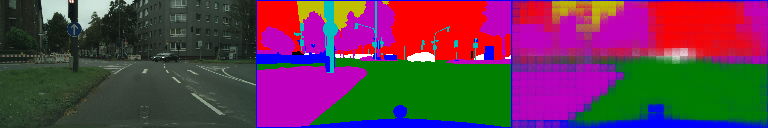

In [39]:
show_results(img,mask,model)

